In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import shap
from importlib.metadata import version

print("Pandas version: " + str(pd.__version__))
print("Numpy version: " + str(np.__version__))
print("Scikit-learn version: " + str(version("scikit-learn")))
print("Shap version: " + str(shap.__version__))

Pandas version: 2.3.3
Numpy version: 2.3.4
Scikit-learn version: 1.7.2
Shap version: 0.49.1


In [2]:
# load the target encoded data
with open('../data/temp/target_encoded_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']
encoder = data['encoder']
features = data['feature_names']
category_mappings = data['category_mappings']

print(f"Loaded: {data['encoding_method']}")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"Features: {features}")

Loaded: standard_target_encoding
X_train: (5769, 20)
X_val: (722, 20)
Features: ['health_service_area', 'hospital_county', 'permanent_facility_id', 'age_group', 'zip_code', 'gender', 'race', 'ethnicity', 'type_of_admission', 'patient_disposition', 'ccsr_procedure_description', 'apr_drg_description', 'apr_mdc_description', 'apr_severity_of_illness_description', 'apr_risk_of_mortality', 'apr_medical_surgical_description', 'payment_typology_1', 'payment_typology_2', 'payment_typology_3', 'emergency_department_indicator']


In [3]:
# fit a random forest model

y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

rf = RandomForestRegressor(
    n_estimators = 500, 
    max_depth = 15, 
    min_samples_leaf = 20,
    n_jobs = -1,
    random_state = 42
)

rf.fit(X_train, y_train_orig)

y_val_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"Random forest on original scale LoS (n estimators: 500; max depth: 15; min samples per leaf: 20):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Random forest on original scale LoS (n estimators: 500; max depth: 15; min samples per leaf: 20):
RMSE: 4.733, MAE: 2.312, R2: 0.417


In [4]:
# create grid search
# runtime: ~ 8 min

param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10, 20],
    'max_features': ['sqrt', 'log2', 0.3, 0.5, None],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

rf_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = param_dist,
    n_iter = 50,
    cv = 10,
    scoring = 'neg_mean_squared_error',
    verbose = 2,
    random_state = 42
)

rf_search.fit(X_train, y_train_orig)

print("Best parameters:", rf_search.best_params_)
best_rf = rf_search.best_estimator_

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_split=2, n_estimators=500; total time=   0.5s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=20, min_samples_spl

In [5]:
# fit the random forest model with the best hyperparameters
y_train_orig = np.exp(y_train)  # undo log transform
y_val_orig = np.exp(y_val)

rf = RandomForestRegressor(
    n_estimators = 100, 
    min_samples_split = 2,
    min_samples_leaf = 20,
    max_features = 0.3,
    max_depth = 15, 
    bootstrap = False,
    n_jobs = -1,
    random_state = 42
)

rf.fit(X_train, y_train_orig)

y_val_pred = rf.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))
mae = mean_absolute_error(y_val_orig, y_val_pred)
r2 = r2_score(y_val_orig, y_val_pred)

print(f"Random forest on original scale LoS (n estimators: 100; max depth: 15; min samples per leaf: 20):")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R2: {r2:.3f}")

Random forest on original scale LoS (n estimators: 100; max depth: 15; min samples per leaf: 20):
RMSE: 4.544, MAE: 2.307, R2: 0.462


In [6]:
# 10-fold cross-validation on training set
rf = RandomForestRegressor(
    n_estimators = 100,
    min_samples_split = 2,
    min_samples_leaf = 20,
    max_features = 0.3,
    max_depth = 15,
    bootstrap = False,
    n_jobs = -1,
    random_state = 42
)

# 10-fold cross-validation on training set
cv_scores = cross_val_score(
    rf, 
    X_train, 
    y_train_orig, 
    cv = 10, 
    scoring = 'neg_mean_squared_error', 
    n_jobs = -1
)

cv_rmse = np.sqrt(-cv_scores)

print("10-fold CV RMSE for each fold:", cv_rmse)
print("Mean CV RMSE:", cv_rmse.mean())
print("Std of CV RMSE:", cv_rmse.std())

10-fold CV RMSE for each fold: [5.23474624 4.96641638 3.56597663 5.2616576  6.97805857 3.07081264
 5.74970095 5.75438168 5.19090768 4.00942325]
Mean CV RMSE: 4.9782081616738685
Std of CV RMSE: 1.0936033742907982


In [7]:
# fit RF on full training set
rf.fit(X_train, y_train_orig)

# predictions
y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)

# compute metrics
train_rmse = np.sqrt(mean_squared_error(y_train_orig, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred))

train_mae = mean_absolute_error(y_train_orig, y_train_pred)
val_mae = mean_absolute_error(y_val_orig, y_val_pred)

train_r2 = r2_score(y_train_orig, y_train_pred)
val_r2 = r2_score(y_val_orig, y_val_pred)

print(f"Train RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R2: {train_r2:.3f}")
print(f"Validation RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, R2: {val_r2:.3f}")

Train RMSE: 4.624, MAE: 2.124, R2: 0.441
Validation RMSE: 4.544, MAE: 2.307, R2: 0.462


No obvious signs of overfitting.

Conduct feature importance analysis.

In [8]:
# fit the random forest model with the best hyperparameters
y_train_orig = np.exp(y_train)
y_val_orig = np.exp(y_val)

rf = RandomForestRegressor(
    n_estimators = 100, 
    min_samples_split = 2,
    min_samples_leaf = 20,
    max_features = 0.3,
    max_depth = 15, 
    bootstrap = False,
    n_jobs = -1,
    random_state = 42
)

rf.fit(X_train, y_train_orig)

y_val_pred = rf.predict(X_val)

feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feature_importances)

                                feature  importance
11                  apr_drg_description    0.192120
15     apr_medical_surgical_description    0.190840
9                   patient_disposition    0.162561
13  apr_severity_of_illness_description    0.141162
14                apr_risk_of_mortality    0.084949
10           ccsr_procedure_description    0.078498
2                 permanent_facility_id    0.028025
3                             age_group    0.023155
4                              zip_code    0.014194
0                   health_service_area    0.013967
1                       hospital_county    0.013079
12                  apr_mdc_description    0.010839
16                   payment_typology_1    0.008639
7                             ethnicity    0.008070
6                                  race    0.006835
17                   payment_typology_2    0.006124
5                                gender    0.005511
18                   payment_typology_3    0.005459
8           

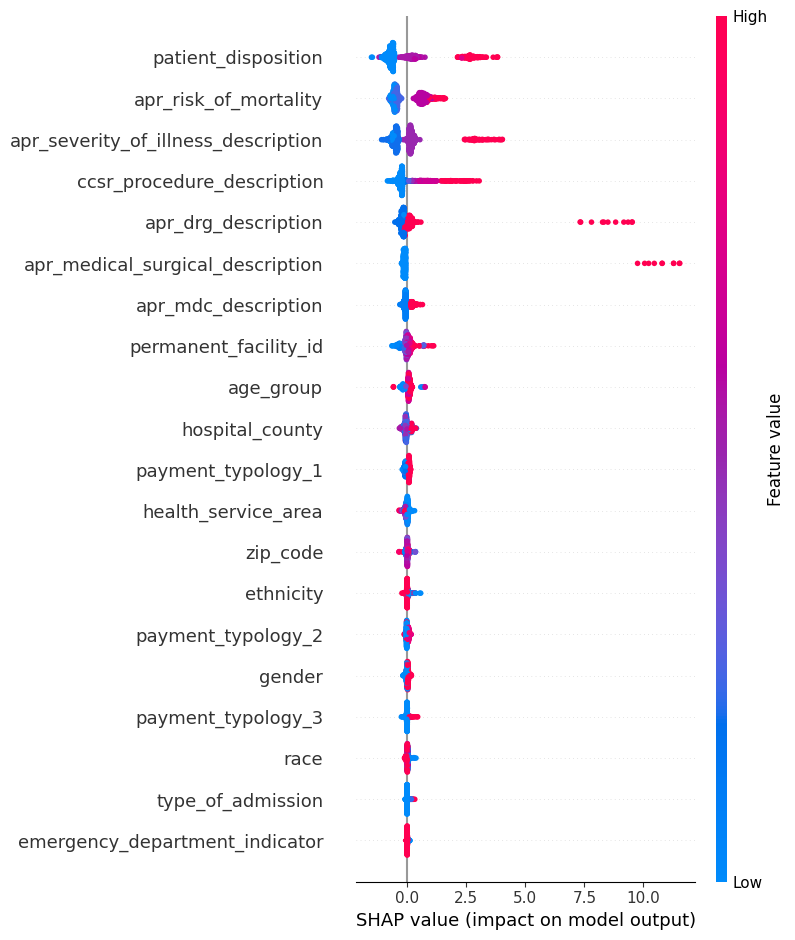

                                feature  mean_abs_shap
9                   patient_disposition       0.908636
14                apr_risk_of_mortality       0.614697
13  apr_severity_of_illness_description       0.565639
10           ccsr_procedure_description       0.453884
11                  apr_drg_description       0.305907
15     apr_medical_surgical_description       0.250565
12                  apr_mdc_description       0.137573
2                 permanent_facility_id       0.127901
3                             age_group       0.100119
1                       hospital_county       0.091950
16                   payment_typology_1       0.069613
0                   health_service_area       0.052000
4                              zip_code       0.037097
7                             ethnicity       0.036821
17                   payment_typology_2       0.036762
5                                gender       0.032592
18                   payment_typology_3       0.029712
6         

In [9]:
# shap analysis

explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_val)

# summary plot (bee swarm)
shap.summary_plot(shap_values, X_val)

# mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_val.columns,
    'mean_abs_shap': np.abs(shap_values.values).mean(axis = 0)
}).sort_values(by = 'mean_abs_shap', ascending = False)

print(shap_importance)

Summary of predictors of length of stay (LoS)

Analysis of the random forest model with target-encoded features predicting LoS, together with SHAP values, indicates that `patient_disposition` and `apr_risk_of_mortality` are the strongest predictors. This is broadly consistent with the OLS model findings, although in OLS, `apr_severity_of_illness_description` was the second strongest and `apr_risk_of_mortality` was third.

Other important features in both models, according to SHAP scores and OLS coefficients, include `ccsr_procedure_description`, `apr_drg_description`, and `apr_mdc_description`. `apr_medical_surgical_description` has a relatively large SHAP score in the random forest model and was ranked high in terms of OLS coefficient magnitude, though it was lower in the OLS SHAP ranking.

Beyond the top features, rankings differ slightly to moderately between the OLS and random forest models, although the differences in importance magnitudes are small.

In [10]:
rf_model = {
    'rf_model': rf,
    'encoder': encoder,
    'category_mappings': category_mappings,
    'feature_names': X_train.columns
}

# save to file
with open('../models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)